In [1]:
import learn2learn as l2l
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import sys
import argparse
import os
from run_MAML_04 import test2 as test_maml
from run_MMAML_04 import test as test_mmaml


sys.path.insert(1, "..")

from ts_dataset import TSDataset
from base_models import LSTMModel, FCN
from metrics import torch_mae as mae
import copy
from pytorchtools import EarlyStopping
from eval_base_models import test, train, freeze_model
from torch.utils.data import Dataset, DataLoader
from ts_dataset import DomainTSDataset, SimpleDataset
from multimodallearner import get_task_encoder_input
from multimodallearner import LSTMDecoder, Lambda, MultimodalLearner
from metalearner import MetaLearner
from meta_base_models import LinearModel, Task
from pytorchtools import EarlyStopping, to_torch

In [2]:
meta_info = {"POLLUTION": [5, 50, 14],
             "HR": [32, 50, 13],
             "BATTERY": [20, 50, 3] }

lower_trial = 0
upper_trial = 3
learning_rate = 0.01
meta_learning_rate = 0.005
adaptation_steps = 10
batch_size = 20
model_name = "LSTM"
is_test = 1
patience_stopping = 20
epochs = 1000
noise_level = 0.0
noise_type = "additive"
loss_fn = mae

dataset_name = "BATTERY"

window_size, task_size, input_dim = meta_info[dataset_name]

train_data = pickle.load(  open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
train_data_ML = pickle.load( open( "../../Data/TRAIN-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
validation_data = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
validation_data_ML = pickle.load( open( "../../Data/VAL-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )
test_data = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-NOML.pickle", "rb" ) )
test_data_ML = pickle.load( open( "../../Data/TEST-"+dataset_name+"-W"+str(window_size)+"-T"+str(task_size)+"-ML.pickle", "rb" ) )


n_layers_task_net = 2
n_layers_task_encoder = 1
n_layers_task_decoder = 1

hidden_dim_task_net = 120
hidden_dim_encoder = 120
hidden_dim_decoder = 120

# fixed values
input_dim_task_net = input_dim
input_dim_task_encoder = input_dim + 1
output_dim_task_net = 1
output_dim_task_decoder = input_dim + 1
output_dim = 1
modulate_task_net = True



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


task_net = LSTMModel(batch_size=batch_size,
                     seq_len=window_size,
                     input_dim=input_dim_task_net,
                     n_layers=n_layers_task_net,
                     hidden_dim=hidden_dim_task_net,
                     output_dim=output_dim_task_net)

task_encoder = LSTMModel(batch_size=batch_size,
                         seq_len=task_size,
                         input_dim=input_dim_task_encoder,
                         n_layers=n_layers_task_encoder,
                         hidden_dim=hidden_dim_encoder,
                         output_dim=1)

task_decoder = LSTMDecoder(batch_size=1,
                           n_layers=n_layers_task_decoder,
                           seq_len=task_size,
                           output_dim=output_dim_task_decoder,
                           hidden_dim=hidden_dim_encoder,
                           latent_dim=hidden_dim_decoder,
                           device=device)

lmbd = Lambda(hidden_dim_encoder, hidden_dim_task_net)


multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
multimodal_learner.to(device)

output_layer = nn.Linear(120, 1)
output_layer.to(device)

maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
opt = optim.Adam(list(maml.parameters()) + list(multimodal_learner.parameters()), lr=meta_learning_rate)


task_data_train = torch.FloatTensor(get_task_encoder_input(train_data_ML))
task_data_validation = torch.FloatTensor(get_task_encoder_input(validation_data_ML))
task_data_test = torch.FloatTensor(get_task_encoder_input(test_data_ML))


In [158]:
def MAPE (y_pred, y_true):
    return torch.mean((y_true - y_pred+1).abs() / (y_true.abs()+1))

def test_debug(loss_fn, maml, multimodal_model, task_data, dataset_name, data_ML, adaptation_steps, learning_rate, noise_level, noise_type, is_test = True, horizon = 10):
    
    total_tasks = len(data_ML)
    task_size = data_ML.x.shape[-3]
    input_dim = data_ML.x.shape[-1]
    window_size = data_ML.x.shape[-2]
    output_dim = data_ML.y.shape[-1]

    if is_test:
        step = total_tasks//100

    else:
        step = 1

    step = 1 if step == 0 else step
    grid = [0., noise_level]
    accum_error = 0.0
    accum_y = 0.0
    accum_std = 0.0
    count = 1.0
    y_pred_hist = np.empty((50*horizon,1))
    y_true_hist = np.empty((50*horizon,1))

    for task_idx in range(0, (total_tasks-horizon-1), step):

        temp_file_idx = data_ML.file_idx[task_idx:task_idx+horizon+1]
        if(len(np.unique(temp_file_idx))>1):
            print("continue...")
            continue
            
        learner = maml.clone() 

        x_spt, y_spt = data_ML[task_idx]
        x_qry = data_ML.x[(task_idx+1):(task_idx+1+horizon)].reshape(-1, window_size, input_dim)
        y_qry = data_ML.y[(task_idx+1):(task_idx+1+horizon)].reshape(-1, output_dim)
        task = task_data[task_idx:task_idx+1].cuda()

        x_spt, y_spt = to_torch(x_spt), to_torch(y_spt)
        x_qry = to_torch(x_qry)
        y_qry = to_torch(y_qry)


        epsilon = grid[np.random.randint(0,len(grid))]

        if noise_type == "additive":
            y_spt = y_spt+epsilon
            y_qry = y_qry+epsilon

        else:
            y_spt = y_spt*(1+epsilon)
            y_qry = y_qry*(1+epsilon)

        for step in range(adaptation_steps):

            x_encoding, _  = multimodal_model(x_spt, task, output_encoding=True)
            pred = learner(x_encoding)
            error = loss_fn(pred, y_spt)
            learner.adapt(error)

        x_encoding, _  = multimodal_model(x_qry, task, output_encoding=True)
        y_pred = learner(x_encoding)
        
        y_pred = torch.clamp(y_pred, 0, 1)
        error = MAPE(y_pred, y_qry)
        
        instant_error = torch.abs(y_qry-y_pred)
        where = np.where(instant_error.detach().cpu().numpy()>0.4)
        if(where[0].shape[0]>1):
            print("task id", task_idx)
            print("instant error:", where )
            fig = plt.figure()
            plt.plot(y_qry.cpu().detach().numpy())
            #plt.plot(y_pred.cpu().detach().numpy())
        
        accum_y += torch.mean(y_qry**2)
        accum_error += error.data
        accum_std += torch.std(y_qry)
        count += 1
        #print(y_true_hist.shape)
        #print(y_qry.shape)

        y_true_hist = np.hstack((y_true_hist, y_qry.cpu().numpy()))
        y_pred_hist = np.hstack((y_pred_hist, y_pred.detach().cpu().numpy()))
        
    error = accum_error/count
    y_mean = accum_y/count
    y_std = accum_std/count
    
    return error.cpu().numpy(), y_mean.cpu().numpy(), y_std.cpu().numpy() , y_true_hist, y_pred_hist

In [159]:
test_data_ML.file_idx[5018:5030]

[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28]

In [162]:
np.max(test_data_ML.file_idx)

29

0
task id 5022
instant error: (array([ 7, 26], dtype=int64), array([0, 0], dtype=int64))
hi: (5150,)
(array([   0,    1,    2, ..., 5147, 5148, 5149], dtype=int64),)
[0.         0.99215901 0.97717136 ... 0.94399631 0.93822294 0.93124068]
mean error: 0.0020538549689413273
continue...
continue...
continue...
continue...
continue...
continue...
continue...
continue...
hi: (47500,)
(array([   0,    1,    2, ..., 4747, 4748, 4749], dtype=int64),)
[1.37654021e-311 9.92159009e-001 9.77171361e-001 ... 9.43996310e-001
 9.38222885e-001 9.31240678e-001]
mean error: 0.001118039093519512
(array([4750, 4751, 4752, ..., 9497, 9498, 9499], dtype=int64),)
[5.         0.99215901 0.97717279 ... 0.94218493 0.93955946 0.93583328]
mean error: 0.0012248874589016563
(array([ 9500,  9501,  9502, ..., 14247, 14248, 14249], dtype=int64),)
[10.          0.99215901  0.97717422 ...  0.93923658  0.93910629
  0.92719501]
mean error: 0.0012016456880067524
(array([14250, 14251, 14252, ..., 18997, 18998, 18999], dtype=i

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory.

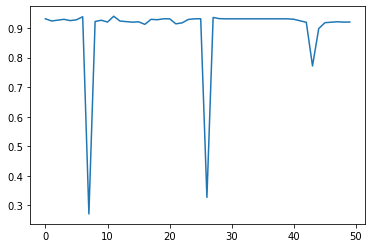

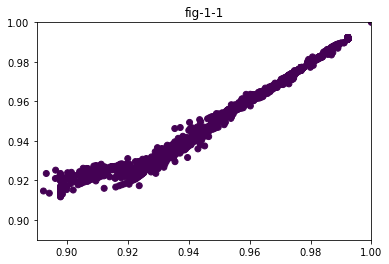

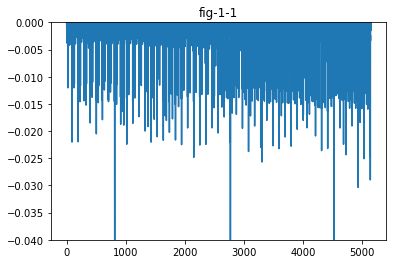

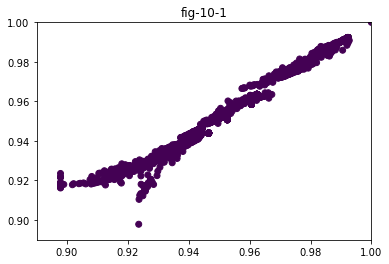

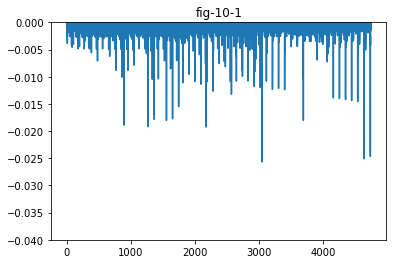

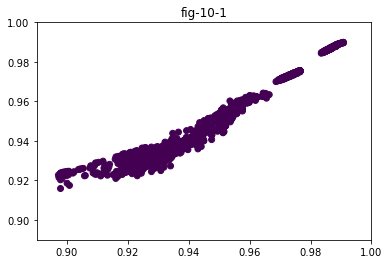

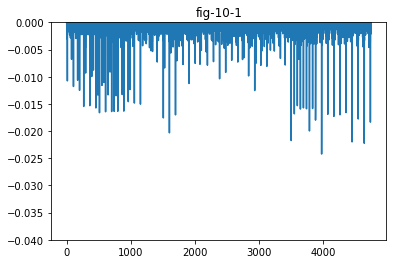

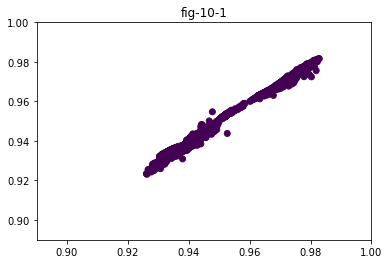

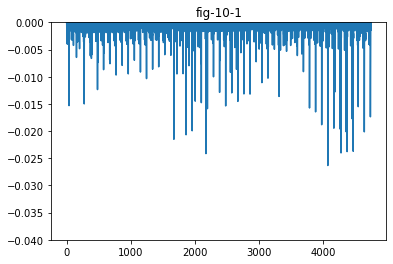

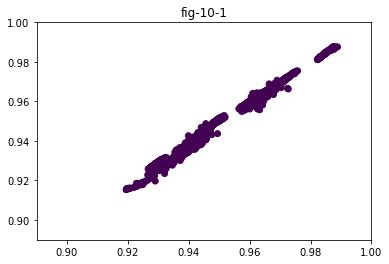

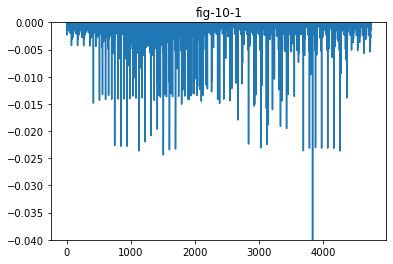

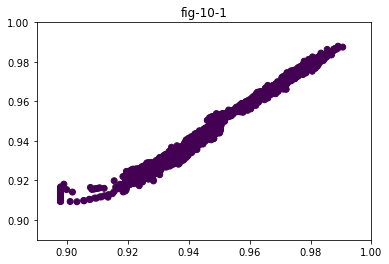

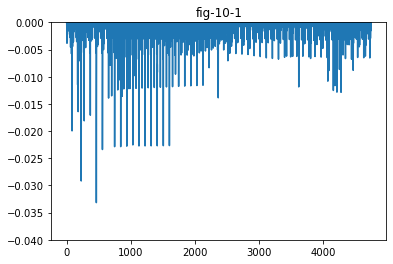

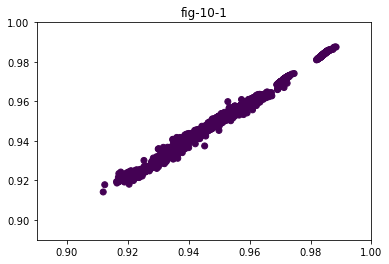

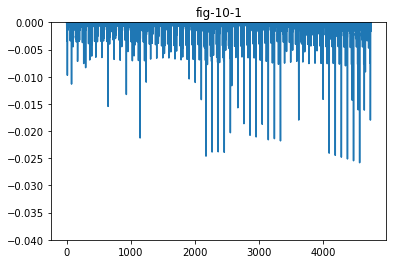

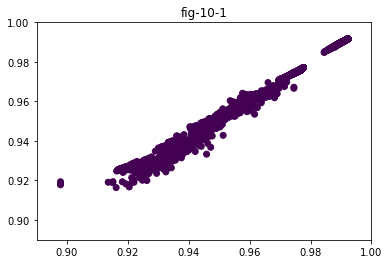

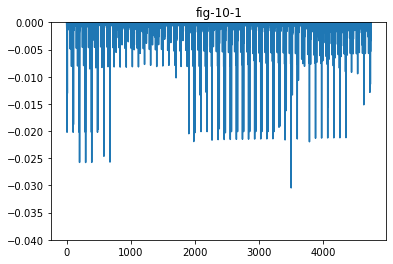

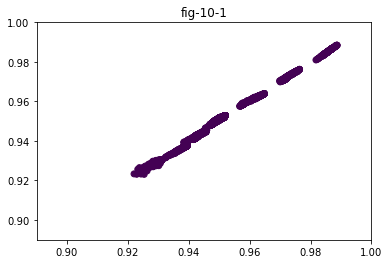

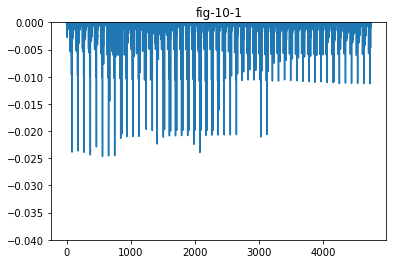

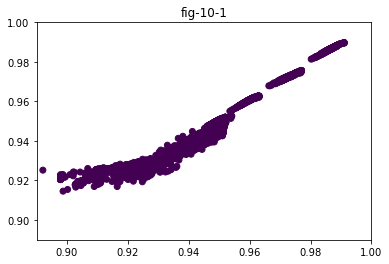

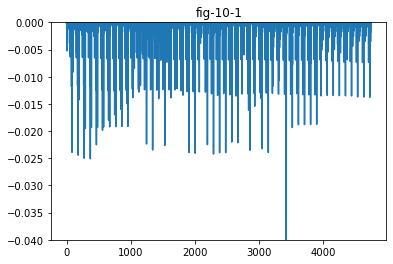

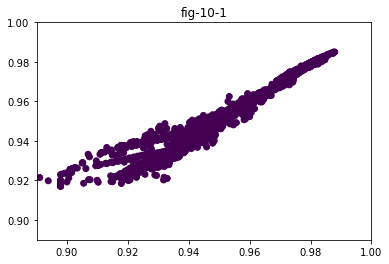

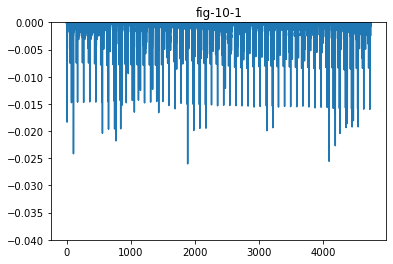

In [160]:

learning_rate = 0.0001


loss_hist_trials= []
y_true_trials = []
y_pred_trials = []
loss_fn = mae

experiment_id = "21_COMPARISON"

for trial in range(1):

    
    output_directory = "../../Models/"+dataset_name+"_"+model_name+"_MMAML/"+str(trial)+"/"
    save_model_file_ = output_directory + experiment_id + "_encoder_model.pt"
    save_model_file_2 = output_directory + experiment_id + "_model.pt"



    multimodal_learner = MultimodalLearner(task_net, task_encoder, task_decoder, lmbd, modulate_task_net)
    multimodal_learner.to(device)

    output_layer = nn.Linear(120, 1)
    output_layer.to(device)

    maml = l2l.algorithms.MAML(output_layer, lr=learning_rate, first_order=False)
    
    
    multimodal_learner.load_state_dict(torch.load(save_model_file_))
    maml.load_state_dict(torch.load(save_model_file_2))
    
    print(trial)

    loss_hist_test1 =[]
    y_hist_1 = []

    for horizon in [1,10]:
        for adaptation_steps in [1]:
            multimodal_learner.load_state_dict(torch.load(save_model_file_))
            maml.load_state_dict(torch.load(save_model_file_2))
            loss, y_mean, y_std, y_true_hist, y_pred_hist = test_debug(loss_fn, maml, multimodal_learner, task_data_test, dataset_name, test_data_ML, adaptation_steps, learning_rate, noise_level, noise_type,horizon=horizon)
            loss_hist_test1.append({"H": horizon, "adapt": adaptation_steps, "MAPE":float(loss), "y_mean": float(y_mean), "trial": trial, "y_std": float(y_std)})
            
            idx = np.arange(y_true_hist.shape[0]*y_true_hist.shape[1])
            idx2 = np.array([i//(50*y_true_hist.shape[1]) for i in idx])
            

            print("hi:", idx2.shape)
            
            for i in range(max(idx2)+1):
                fig = plt.figure()
                plt.xlim(0.89, 1)
                plt.ylim(0.89, 1)
                plt.title("fig-"+str(horizon)+"-"+str(adaptation_steps))
                idx = np.where(idx2==i)
                print(idx)
                plt.scatter(y_true_hist.T.reshape(-1)[idx], y_pred_hist.T.reshape(-1)[idx], c=np.array(idx2)[idx])
                #plt.scatter(y_true_hist.reshape(-1)[10:1000000], y_pred_hist.reshape(-1)[10:1000000], c=idx2[10:1000000])
                #plt.legend([str(i) for i in np.arange(horizon)])
            
                fig = plt.figure()
                #plt.xlim(0.89, 1)
                plt.ylim(-0.04, 0)
                plt.title("fig-"+str(horizon)+"-"+str(adaptation_steps))
                print(y_pred_hist.reshape(-1)[idx])
                plt.plot(y_true_hist.reshape(-1)[idx]- y_pred_hist.reshape(-1)[idx])
                print("mean error:", np.nanmean(np.abs(y_true_hist.reshape(-1)[idx]- y_pred_hist.reshape(-1)[idx])))
                y_pred_trials.append(y_pred_hist)
                y_true_trials.append(y_true_hist)
    loss_hist_trials +=loss_hist_test1
            

In [135]:
print(y_pred_trials[0].shape)
print(y_true_trials[1].shape)
MAPE(torch.FloatTensor(y_pred_trials[0][:,:101].reshape(-1))[1:], torch.FloatTensor(y_true_trials[0][:,:101].reshape(-1))[1:])

(50, 103)
(500, 95)


tensor(0.5164)

In [ ]:
torch.FloatTensor(y_pred_trials[1][:50].reshape(-1))[1:], torch.FloatTensor(y_true_trials[1][:50].reshape(-1))[1:]

C:\Users\Sebastian\Anaconda3\envs\pytorch12\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


(array([ 815, 2772, 4523], dtype=int64),)

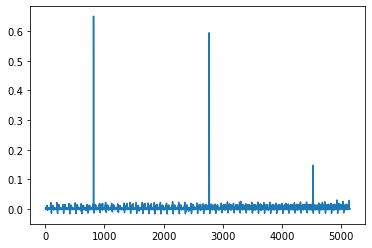

In [102]:
plt.plot(y_pred_trials[0].reshape(-1)- y_true_trials[0].reshape(-1))
error = y_pred_trials[0].reshape(-1)- y_true_trials[0].reshape(-1)
np.where(error>0.1)

In [104]:
y_pred_trials[0].reshape(-1).shape

(5150,)

In [87]:
y_pred_trials[0][:1,:101]-y_pred_trials[1][:1,:101]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -5.96046448e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.19209290e-07,
         0.00000000e+00, -5.96046448e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.52246356e-02,
        -5.08861542e-02,  1.42028928e-02,  1.26427412e-02,
         9.99706984e-03,  7.15982914e-03,  7.18200207e-03,
         7.67302513e-03, -3.82085443e-02,  2.35961080e-02,
        -3.89921069e-02,  4.53163385e-02, -4.46372628e-02,
         1.10946298e-02,  8.31639767e-03,  1.32631660e-02,
         9.34982300e-03,  8.32903385e-03,  7.70264864e-03,
        -1.79484487e-02, -2.60569453e-02,  3.76139879e-0

In [96]:
import pandas as pd
pd.DataFrame({"a":list(y_pred_trials[0][:1,:101][0]), "b":list(y_pred_trials[1][:1,:101][0]) }).to_csv("test.csv")

In [89]:
y_pred_trials[0][:1,:101]

array([[-0.01521623,  0.99215901,  0.97717136,  0.96351856,  0.95269889,
         0.94650394,  0.93564725,  0.99230397,  0.94411761,  0.96060979,
         0.9334864 ,  0.96066713,  0.93352711,  0.95139569,  0.98764664,
         0.97352344,  0.96073472,  0.95230716,  0.94320571,  0.93484938,
         0.9723447 ,  0.94146997,  0.92393422,  0.97555935,  0.96335506,
         0.95247811,  0.94130415,  0.9368968 ,  0.93113625,  0.92165589,
         0.93688053,  0.98776668,  0.97356379,  0.96092105,  0.95092404,
         0.94376421,  0.93658221,  0.9289093 ,  0.96711785,  0.94352174,
         0.98251373,  0.93719739,  0.98183465,  0.97074002,  0.96242362,
         0.94916046,  0.93981063,  0.93148148,  0.92377883,  0.94172728,
         0.96778423,  0.93017024,  0.95234168,  0.93412507,  0.96147621,
         0.93556589,  0.98544288,  0.97200292,  0.95994705,  0.95014584,
         0.94481951,  0.93716884,  0.92835039,  0.95641768,  0.93620539,
         0.96281129,  0.93294758,  0.95778286,  0.9

In [136]:
import pandas as pd
pd.DataFrame(loss_hist_trials).groupby(["H", "adapt"]).mean()

,,MAPE,y_mean,trial,y_std
H,adapt,,,,
1,1,0.507087,0.894493,0,0.003248
10,1,0.506977,0.896164,0,0.003254


In [82]:
y_true_hist.shape

(47001, 1)